In [1]:
import pandas as pd
import numpy as np

!pip install lxml
import lxml

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

     |████████████████████████████████| 5.5MB 6.2MB/s eta 0:00:01     |██████████████████████████▏     | 4.5MB 6.2MB/s eta 0:00:01     |███████████████████████████████▍| 5.4MB 6.2MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         394 KB

The following NEW packages will be INSTALLED:

  geographiclib      con

## 1. Read Totonto Neighborhood Data from wikipedia

In [2]:
#read data
neighborhoods = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

#remove Not assigned in Borough
neighborhoods = neighborhoods[neighborhoods['Borough']!='Not assigned']

#merge line
neighborhoods = neighborhoods.groupby(['Postal Code','Borough'], as_index=False).agg(lambda x: ', '.join(x))

#fill in Not assigned Neigbohood as Borough
mask = neighborhoods['Neighborhood'] == "Not assigned"
neighborhoods.loc[mask, 'Neighborhood'] = neighborhoods.loc[mask, 'Borough']

neighborhoods

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [3]:
neighborhoods.shape[0]

103

## 2. Adding Geographical Coordinates data to Neighborhood Data

In [4]:
#read geographical coordinates data
df_coordinates = pd.read_csv("http://cocl.us/Geospatial_data")

#merge
neighborhoods = neighborhoods.merge(df_coordinates, on = 'Postal Code', how = 'left')

In [5]:
neighborhoods

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


## 3. Explore and cluster the neighborhoods in Toronto, by considering the word Toronto in boroughs

### a. Preparing the data with the borough containing Toronto

In [6]:
toronto_neigh = neighborhoods[neighborhoods['Borough'].astype(str).str.contains('Toronto')]
toronto_neigh

,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


In [7]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### b. Create a map of Toronto with neighborhoods superimposed on top.

In [8]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_neigh['Latitude'], toronto_neigh['Longitude'], toronto_neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### c. Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

In [10]:
CLIENT_ID = 'K31PDVDGR4TO3DAIIGC2UEGB4AWWFVDDKPZGHRBS3E2KZAYA' # your Foursquare ID
CLIENT_SECRET = '0ASADOMPAD1KLDCIV1B0541EPMKRS4IM2G4QA40YMNCYGSPQ' # your Foursquare Secret
VERSION = '20200501' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K31PDVDGR4TO3DAIIGC2UEGB4AWWFVDDKPZGHRBS3E2KZAYA
CLIENT_SECRET:0ASADOMPAD1KLDCIV1B0541EPMKRS4IM2G4QA40YMNCYGSPQ


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### d. Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [12]:
toronto_venues = getNearbyVenues(names=toronto_neigh['Neighborhood'],
                                   latitudes=toronto_neigh['Latitude'],
                                   longitudes=toronto_neigh['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

#### Let's preview the resulting dataframe

In [13]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


#### Let's check how many venues were returned for each neighborhood

In [14]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,74,74,74,74,74,74
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,32,32,32,32,32,32


#### Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 231 uniques categories.


### d. Analyze Each Neighborhood

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.014706,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.000000,0.000000
5,Christie,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.027027,0.013514,0.0000,0.0000,0.000,0.0000,0.000,0.013514,0.000000,...,0.013514,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.03125,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [82]:
toronto_grouped_jp = toronto_grouped[['Neighborhood', 'Japanese Restaurant']]
toronto_grouped_jp

,Neighborhood,Japanese Restaurant
0,Berczy Park,0.016949
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.058824
5,Christie,0.000000
6,Church and Wellesley,0.054054
7,"Commerce Court, Victoria Hotel",0.030000
8,Davisville,0.000000
9,Davisville North,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.08
1  Cocktail Bar  0.05
2          Café  0.03
3      Beer Bar  0.03
4    Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
                   venue  freq
0                   Café  0.13
1  Performing Arts Venue  0.09
2            Coffee Shop  0.09
3         Breakfast Spot  0.09
4                    Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Pizza Place  0.06
2       Auto Workshop  0.06
3          Comic Shop  0.06
4          Restaurant  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0     Airport Service  0.19
1      Airport Lounge  0.12
2    Airport Terminal  0.12
3             Airport  0.06
4  Airport Food Court  0.06


----Central Bay Street----
                 venue  freq
0

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Café,Seafood Restaurant,Bakery,Restaurant,Cheese Shop,Shopping Mall,Bistro
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Intersection,Italian Restaurant,Convenience Store,Nightclub,Bakery,Pet Store
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Pizza Place,Skate Park,Brewery,Burrito Place,Spa,Farmers Market,Fast Food Restaurant,Restaurant,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Plane,Sculpture Garden
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Thai Restaurant,Bar,Burger Joint,Bubble Tea Shop,Salad Place


### e.  Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [33]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped_jp.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 2, 1, 2, 3, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [35]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_grouped_jp.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

In [36]:
toronto_merged

,Neighborhood,Japanese Restaurant,Cluster Labels
0,Berczy Park,0.016949,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,1
2,"Business reply mail Processing Centre, South C...",0.000000,1
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,1
4,Central Bay Street,0.058824,2
5,Christie,0.000000,1
6,Church and Wellesley,0.054054,2
7,"Commerce Court, Victoria Hotel",0.030000,3
8,Davisville,0.000000,1
9,Davisville North,0.000000,1


In [38]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

toronto_merged

,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.016949,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.016949,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.016949,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.016949,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.016949,0,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum
...,...,...,...,...,...,...,...,...,...
38,"University of Toronto, Harbord",0.057143,2,43.662696,-79.400049,DT Bistro,43.662375,-79.405734,Café
38,"University of Toronto, Harbord",0.057143,2,43.662696,-79.400049,Comfort Zone,43.658397,-79.400274,Nightclub
38,"University of Toronto, Harbord",0.057143,2,43.662696,-79.400049,The Beer Store,43.665385,-79.403477,Beer Store
38,"University of Toronto, Harbord",0.057143,2,43.662696,-79.400049,East of Brunswick,43.665609,-79.403324,Pub


Finally, let's visualize the resulting clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

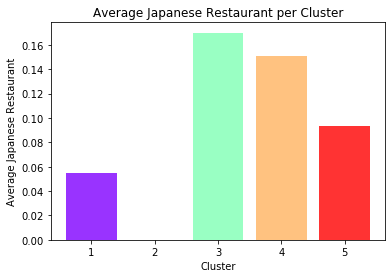

In [91]:
import matplotlib.pyplot as plt
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = toronto_merged[['Neighborhood','Cluster Labels','Japanese Restaurant']].drop_duplicates().groupby("Cluster Labels").sum()['Japanese Restaurant']
plt.bar(y_pos, performance, align='center', alpha=0.8, color=rainbow)
plt.xticks(y_pos, objects)
plt.ylabel('Average Japanese Restaurant')
plt.xlabel('Cluster')
plt.title('Average Japanese Restaurant per Cluster')

plt.show()

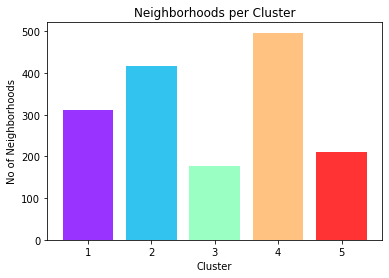

In [52]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = toronto_merged['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=rainbow)
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Neighborhoods per Cluster')

plt.show()

### e. Examine Clusters 

#### Cluster 1: Purple

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Japanese Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0.016949,LCBO,43.642944,-79.372440,Liquor Store
0,0.016949,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,0.016949,Meridian Hall,43.646292,-79.376022,Concert Hall
0,0.016949,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,0.016949,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum
...,...,...,...,...,...
25,0.010638,Soup Nutsy,43.647858,-79.380533,Soup Place
25,0.010638,Starbucks,43.646891,-79.381871,Coffee Shop
25,0.010638,McEwan Foods,43.647160,-79.381044,Deli / Bodega
25,0.010638,Starbucks,43.649028,-79.381593,Coffee Shop


#### Cluster 2: Blue

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Japanese Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
1,0.0,Reebok Crossfit Liberty Village,43.637036,-79.424802,Gym
1,0.0,Pharmacy,43.638090,-79.431810,Bar
1,0.0,Starbucks,43.639090,-79.427622,Coffee Shop
1,0.0,Caffino,43.639021,-79.425289,Italian Restaurant
1,0.0,Louie Craft Coffee,43.639284,-79.425620,Coffee Shop
...,...,...,...,...,...
34,0.0,Nancy's Cheese,43.674851,-79.406753,Cheese Shop
35,0.0,Glen Manor Ravine,43.676821,-79.293942,Trail
35,0.0,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
35,0.0,Grover Pub and Grub,43.679181,-79.297215,Pub


#### Cluster 3: Green

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Japanese Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
4,0.058824,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
4,0.058824,Tim Hortons,43.658570,-79.385123,Coffee Shop
4,0.058824,Somethin' 2 Talk About,43.658395,-79.385338,Middle Eastern Restaurant
4,0.058824,Hailed Coffee,43.658833,-79.383684,Coffee Shop
4,0.058824,Neo Coffee Bar,43.660140,-79.385870,Coffee Shop
...,...,...,...,...,...
38,0.057143,DT Bistro,43.662375,-79.405734,Café
38,0.057143,Comfort Zone,43.658397,-79.400274,Nightclub
38,0.057143,The Beer Store,43.665385,-79.403477,Beer Store
38,0.057143,East of Brunswick,43.665609,-79.403324,Pub


#### Cluster 4: Orange

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Japanese Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
7,0.03,Adelaide Club Toronto,43.649279,-79.381921,Gym / Fitness Center
7,0.03,Canoe,43.647452,-79.381320,Restaurant
7,0.03,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
7,0.03,Mos Mos Coffee,43.648159,-79.378745,Café
7,0.03,Equinox Bay Street,43.648100,-79.379989,Gym
...,...,...,...,...,...
37,0.03,Metropolitan Resto Bar,43.650062,-79.377181,Italian Restaurant
37,0.03,Z-Teca Gourmet Burritos,43.648014,-79.379119,Burrito Place
37,0.03,Sushi-Q,43.647738,-79.379699,Sushi Restaurant
37,0.03,Colibri,43.651041,-79.384065,Taco Place


#### Cluster 5: Red

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Japanese Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
19,0.022727,Bellwoods Brewery,43.647097,-79.419955,Brewery
19,0.022727,OddSeoul,43.646192,-79.419601,Korean Restaurant
19,0.022727,Bang Bang Ice Cream & Bakery,43.646246,-79.419553,Ice Cream Shop
19,0.022727,Pizzeria Libretto,43.648979,-79.420604,Pizza Place
19,0.022727,Foxley Bistro,43.648643,-79.420495,Asian Restaurant
...,...,...,...,...,...
36,0.023256,Menchie's,43.678309,-79.348105,Frozen Yogurt Shop
36,0.023256,LCBO,43.676816,-79.356047,Liquor Store
36,0.023256,Factory Girl,43.676693,-79.356299,American Restaurant
36,0.023256,Kitchen Stuff Plus,43.678613,-79.346422,Furniture / Home Store


In [84]:
tmp = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [85]:
tmp

,Japanese Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
1,0.0,Reebok Crossfit Liberty Village,43.637036,-79.424802,Gym
1,0.0,Pharmacy,43.638090,-79.431810,Bar
1,0.0,Starbucks,43.639090,-79.427622,Coffee Shop
1,0.0,Caffino,43.639021,-79.425289,Italian Restaurant
1,0.0,Louie Craft Coffee,43.639284,-79.425620,Coffee Shop
...,...,...,...,...,...
34,0.0,Nancy's Cheese,43.674851,-79.406753,Cheese Shop
35,0.0,Glen Manor Ravine,43.676821,-79.293942,Trail
35,0.0,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
35,0.0,Grover Pub and Grub,43.679181,-79.297215,Pub


In [89]:
tmp['Venue Category'].drop_duplicates().tail

<bound method NDFrame.tail of 1                       Gym
1                       Bar
1               Coffee Shop
1        Italian Restaurant
1                    Bakery
              ...          
33    Vietnamese Restaurant
34             Burger Joint
34                BBQ Joint
34           History Museum
34               Donut Shop
Name: Venue Category, Length: 139, dtype: object>

In [90]:
 tmp.to_csv('filename.csv',mode = 'a')